In [1]:
# Conectar con Drive
##drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.odr import ODR, Model, Data

In [3]:
def Beta(p, m):
  E_total = np.sqrt(p*p + m*m)
  beta = p/E_total
  return beta

# Momento mínimo necesario con el que una partícula debe viajar en el medio para comenzar a generar radiación de Cherenkov
def p_c(m,n):
  p_c = m/np.sqrt(n*n -1)
  return p_c

def TethavsP(ParticleMass, n, FileName):
    # Se definen arreglos para guardar los valores de momento p y los ángulos de Cherenkov theta_c
    p_values = []
    theta_c_values = []

    # Se calcula el momento mínimo que debe tener la partícula para generar el cono de Cherenkov según su masa y el índice de refracción
    p = ParticleMass / np.sqrt(n * n - 1)

    # Se calculan los ángulos de Cherenkov a partir de variar el momento p
    for _ in range(10000):
        # arreglo que representa a la partícula
        particle = [p, ParticleMass]
        # cálculo del beta a partir del momento y la masa
        beta = Beta(particle[0], particle[1])
        # Cálculo del ángulo de Cherenkov a partir del beta
        cos_theta_c = 1 / (beta * n)
        if cos_theta_c > 1:
            cos_theta_c = 1
        theta_c = np.arccos(cos_theta_c)
        # Nuevo momento, aumentando en 10 MeV
        p += 0.005
        # Agregar los valores de p y theta_c a los arreglos correspondientes
        p_values.append(p)
        theta_c_values.append(theta_c)

    # Crear el arreglo con los datos
    data = np.column_stack((p_values, theta_c_values))  # (x, y)
    # Guardar los datos en Drive
    np.savetxt('/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/' + FileName, data, fmt='%.6f', delimiter='\t')
    return None

def dataPvsTheta(n, IndexName):
  muon_mass = 0.1056583745 # GeV
  proton_mass = 0.93827208816 # GeV
  pion_mass = 0.13957018 # GeV
  kaon_mass = 0.493667 # GeV
  theta_max = np.degrees(np.arccos(1/n))

  TethavsP(muon_mass, n, 'muon_tethavsP_' + IndexName + '.dat')
  TethavsP(proton_mass, n, 'proton_tethavsP_'+ IndexName + '.dat')
  TethavsP(pion_mass, n, 'pion_tethavsP_'+ IndexName + '.dat')
  TethavsP(kaon_mass, n, 'kaon_tethavsP_'+ IndexName + '.dat')
  return theta_max


def PrintPvsTheta(n, IndexName, figsizex, figsizey, xmax, ymax):

  file_paths = ['/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/muon_tethavsP_' + IndexName + '.dat', 
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/proton_tethavsP_'+ IndexName + '.dat',   
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/pion_tethavsP_' + IndexName + '.dat',
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/kaon_tethavsP_' + IndexName + '.dat']

  # Leer los datos de cada archivo y asignarlos a un arreglo.
  data_p_tetha = []
  for path in file_paths:
      data_p_tetha.append(np.loadtxt(path))


  plt.figure(figsize=(figsizex, figsizey))

  # Cuadrícula    
  plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
  plt.minorticks_on()
  plt.grid(which='minor', color='gray', linestyle=':', linewidth='0.5', alpha=0.5)

  colors = ["navy", "red", "green", "purple"]
  labels = ["Muón ($\mu^{+}$)", "Protón ($p$)", "Pión ($\pi^{-}$)", 'Kaón ($K^{-}$)']

  for i in range(len(data_p_tetha)):
    plt.plot(data_p_tetha[i][:,0], np.degrees(data_p_tetha[i][:,1]),label=labels[i], linestyle="-", linewidth=1.5, color=colors[i])


  rango_x = (0, xmax)
  rango_y = (0, ymax)
  plt.xlim(rango_x)
  plt.ylim(rango_y)
  plt.axhline(y=dataPvsTheta(n, IndexName), color='black', linestyle='--')
  plt.legend(fontsize=12)
  plt.xlabel('p (GeV)', fontsize=12)
  plt.ylabel('$\Theta$ (grados)', fontsize=12)

  return None
  
def ExperimentalData(n, particle_data_i, data_i, xmin, xmax, ymin, ymax, title):
  theta_max = np.degrees(np.arccos(1/n))

  plt.figure(figsize=(6, 4))
  # Cuadrícula
  plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
  plt.minorticks_on()
  plt.grid(which='minor', color='gray', linestyle=':', linewidth='0.5', alpha=0.5)

  # Gráfica de los datos y ajuste
  rango_x = (xmin, xmax)
  rango_y = (ymin, ymax)
  plt.xlim(rango_x)
  plt.ylim(rango_y)
  plt.axhline(y=theta_max, color='black', linestyle='--')
  plt.plot(particle_data[particle_data_i][1:,0], particle_data[particle_data_i][1:,3], 'o', markersize=3, color = 'navy', label='Datos de la simulación')
  plt.plot(data[data_i][:,0], np.degrees(data[data_i][:,1]) , label='Ajuste', color="red", linestyle="-", linewidth=1)
  #plt.plot(p_GeV, ModelTheta_P(1, p_GeV), label='Ajuste', color="red", linestyle="-", linewidth=1)
  plt.xlabel('p (GeV)')
  plt.ylabel('$\Theta$ (grados)')
  plt.title(title)
  plt.legend()

  return None

def Cosvs1_B(ParticleMass, n, FileName):
    # Se definen arreglos para guardar los valores de momento p y los ángulos de Cherenkov theta_c
    beta_values = []
    cos_theta_c_values = []

    # Se calcula el momento mínimo que debe tener la partícula para generar el cono de Cherenkov según su masa y el índice de refracción
    p = ParticleMass / np.sqrt(n * n - 1)

    # Se calculan los ángulos de Cherenkov a partir de variar el momento p
    for _ in range(1000):
        # arreglo que representa a la partícula
        particle = [p, ParticleMass]
        # cálculo del beta a partir del momento y la masa
        beta = Beta(particle[0], particle[1])
        # Cálculo del ángulo de Cherenkov a partir del beta
        cos_theta_c = 1 / (beta * n)
        if cos_theta_c > 1:
            cos_theta_c = 1
        theta_c = np.arccos(cos_theta_c)
        # Nuevo momento, aumentando en 10 MeV
        p += 10
        # Agregar los valores de p y theta_c a los arreglos correspondientes
        beta_values.append(1/beta)
        cos_theta_c_values.append(cos_theta_c)

    # Crear el arreglo con los datos
    data = np.column_stack((beta_values, cos_theta_c_values))  # (x, y)
    # Guardar los datos en Drive
    np.savetxt('/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/' + FileName, data, fmt='%.6f', delimiter='\t')
    return None

def SaveFig(FileName):
    plt.savefig('/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/Graphics/'+ FileName, bbox_inches='tight')
    return None

Ángulo de Cherenkov para beta=0.9944644588778273: 42.87 grados
Ángulo de Cherenkov para beta=0.7292562028443856: 1.88 grados
Ángulo de Cherenkov para beta=0.9904001101463388: 42.61 grados


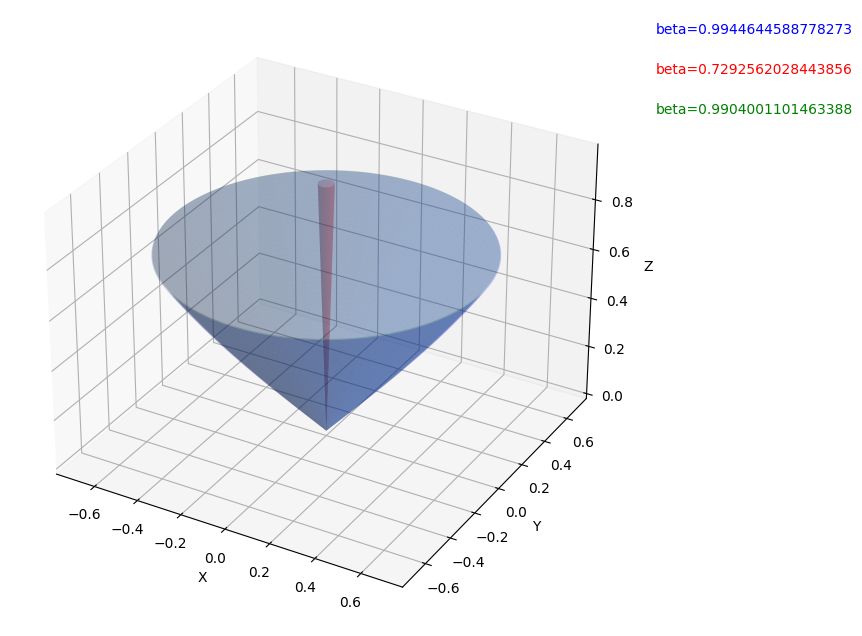

159.16871426580838 0.7518796992481201 1.0000000000000002


In [4]:
# Índices de refracción del medio
indice_refraccion = 1.372  # Ejemplo: agua

# Aquí se definen las partículas en términos de su momento y su masa [p,m], todo en unidades de MeV
muon = [1, 0.1056583745]
proton = [1, 0.93827208816]
pion = [1, 0.13957018]

# Parámetros de la simulación
n_steps = 1000  # Número de pasos
step_length = 1.0  # Longitud del paso
betas = [Beta(muon[0], muon[1]), Beta(proton[0], proton[1]), Beta(pion[0], pion[1])]  # Valores de beta

# Generar trayectoria
theta = np.random.uniform(0, np.pi, n_steps)
phi = np.random.uniform(0, 2 * np.pi, n_steps)

x = step_length * np.sin(theta) * np.cos(phi)
y = step_length * np.sin(theta) * np.sin(phi)
z = np.cumsum(step_length * np.cos(theta))

# Visualizar conos de luz Cherenkov para cada valor de beta
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'red', 'green']  # Colores para los conos

for i, beta in enumerate(betas):
    # Calcular ángulo Cherenkov
    cos_theta_c = 1 / (beta * indice_refraccion)
    theta_c = np.arccos(cos_theta_c)

    # Generar puntos para el cono de luz
    n_points = 100
    theta_cone = np.linspace(0, theta_c, n_points)
    phi_cone = np.linspace(0, 2 * np.pi, n_points)
    theta_cone, phi_cone = np.meshgrid(theta_cone, phi_cone)
    x_cone = step_length * np.sin(theta_cone) * np.cos(phi_cone)
    y_cone = step_length * np.sin(theta_cone) * np.sin(phi_cone)
    z_cone = np.linspace(0, step_length * np.cos(theta_c), n_points)
    z_cone = np.tile(z_cone, (n_points, 1))  # Replicar z_cone para que coincida con las dimensiones de x_cone y y_cone

    # Visualizar cono de luz Cherenkov
    ax.plot_surface(x_cone, y_cone, z_cone, alpha=0.2, color=colors[i])

    # Imprimir ángulo de Cherenkov
    print(f'Ángulo de Cherenkov para beta={beta}: {np.degrees(theta_c):.2f} grados')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Etiquetas fuera de la figura
for i, beta in enumerate(betas):
    fig.text(0.85, 0.85 - i*0.05, f'beta={beta}', color=colors[i])

plt.show()
print(p_c(139.57018, 1.33), Beta(p_c(139.57018, 1.33),139.57018), 1 / ((Beta(p_c(139.57018, 1.33),139.57018)) * 1.33))


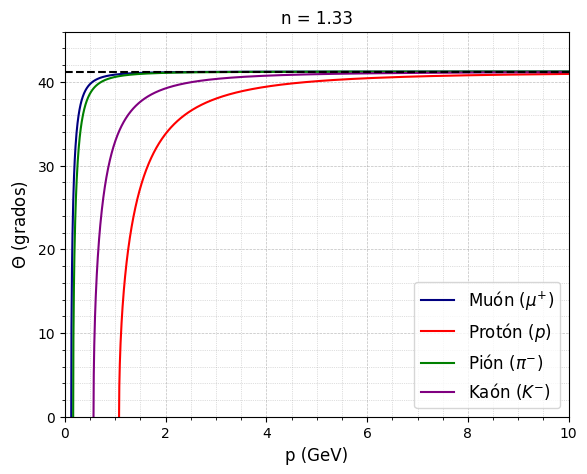

In [ ]:
dataPvsTheta(1.33, 'n1-33')
PrintPvsTheta(1.33, 'n1-33', 6.5, 5, 10, 46)
plt.title('n = 1.33')
SaveFig('ThetavsP_n1-33.pdf')

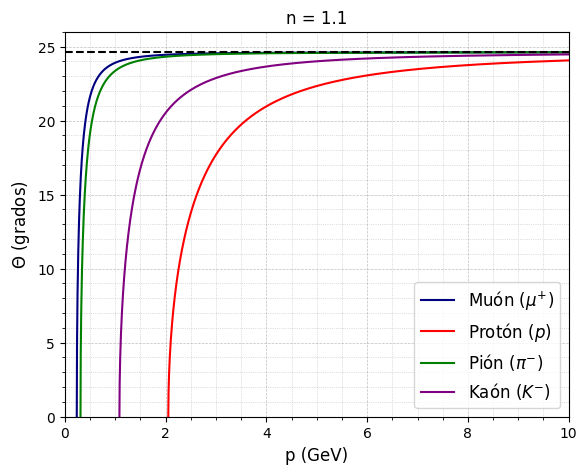

In [ ]:
dataPvsTheta(1.1, 'n1-1')
PrintPvsTheta(1.1, 'n1-1', 6.5, 5, 10, 26)
plt.title('n = 1.1')
SaveFig('ThetavsP_n1-1.pdf')

Text(0.5, 1.0, 'n = 1.111')

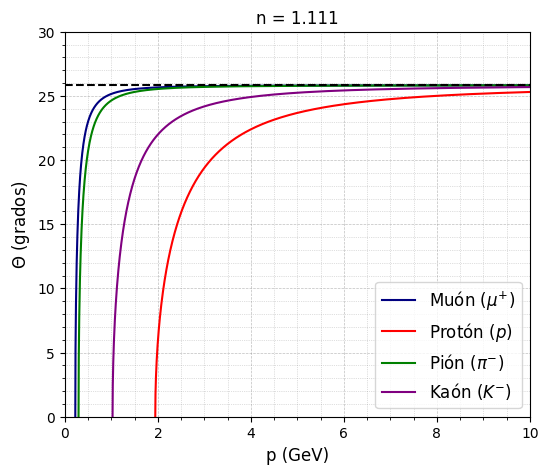

In [ ]:
dataPvsTheta(1.111, 'n1-111')
PrintPvsTheta(1.111, 'n1-111', 6, 5, 10, 30)
plt.title('n = 1.111')

In [ ]:
# En esta sección se ajustarán los datos experimentales a las relaciones mostradas anteriormente

In [5]:
# Definir rutas de los archivos
file_paths = ["/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Simulaciones/data/exported_data/proton_physdata.dat", 
              "/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Simulaciones/data/exported_data/kaon_physdata.dat",   
              "/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Simulaciones/data/exported_data/pion_physdata.dat"]

particle_data = []

for path in file_paths:
        particle_data.append(np.loadtxt(path, delimiter=','))

plt.plot(particle_data[0][:,0], particle_data[0][:,3],'o', markersize=3, color = 'navy')
plt.plot(particle_data[1][:,0], particle_data[1][:,3],'o', markersize=3, color = 'green')
plt.plot(particle_data[2][:,0], particle_data[2][:,3],'o', markersize=3, color = 'red')

FileNotFoundError: ignored

In [ ]:
file_paths_2 = ['/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/muon_tethavsP_n1-11.dat', 
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/proton_tethavsP_n1-1053.dat',   
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/pion_tethavsP_n1-111.dat',
              '/content/drive/MyDrive/UNAL/Semestre 2023-I/Subatómica/Proyecto Final/Python/kaon_tethavsP_n1-1132.dat']

data = []
for path in file_paths_2:
        data.append(np.loadtxt(path))

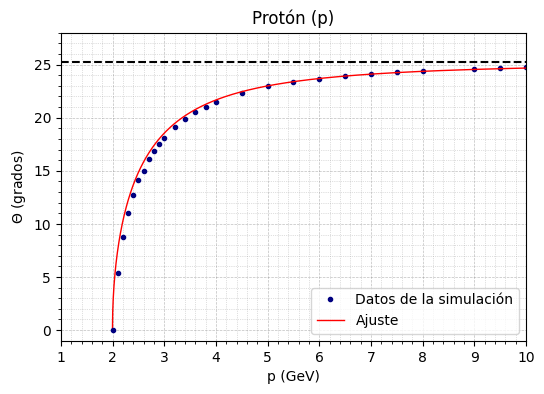

In [ ]:
ExperimentalData(1.1053, 0, 1, 1, 10, -1, 28, 'Protón (p)') # protón
plt.plot(2,0, 'o', markersize = 3, color = 'navy')
SaveFig('ThetavsP_proton.pdf')

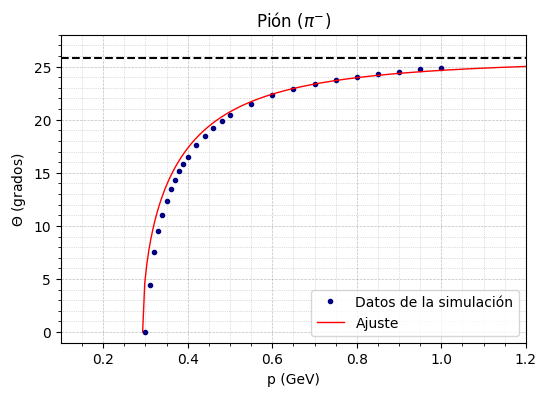

In [ ]:
ExperimentalData(1.111, 2, 2, 0.1, 1.2, -1, 28, 'Pión ($\pi^{-}$)') # pión
plt.plot(0.30, 0, 'o', markersize = 3, color = 'navy')
SaveFig('ThetavsP_pion.pdf')

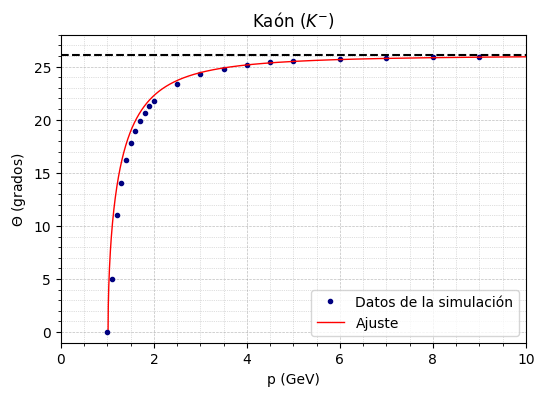

In [ ]:
ExperimentalData(1.1132, 1, 3, 0, 10, -1, 28, 'Kaón ($K^{-}$)') # kaón
plt.plot(1, 0, 'o', markersize = 3, color = 'navy')
SaveFig('ThetavsP_kaon.pdf')

In [ ]:
def ModelTheta_P(B, p_GeV):
    n = B
    m = 0.13957018
    cos_theta_c = (np.sqrt((p_GeV * p_GeV) + (m * m))) / (p_GeV * n)
    theta_c = np.degrees(np.arccos(np.where(cos_theta_c <= 1, cos_theta_c, np.nan)))
    return theta_c

# Datos de las equivalencias de canales y keVs
Theta_c = particle_data[2][1:,3]
p_GeV = particle_data[2][1:,0]

# Estimación inicial de los parámetros (n, m) 
p0 = [1.1]

# Definir el modelo para ODR
model = Model(ModelTheta_P)

# Crear el objeto Data para ODR
data_odr = Data(p_GeV, Theta_c) 

# Crear el objeto ODR
odr = ODR(data_odr, model, beta0=p0)

# Ejecutar el ajuste
out = odr.run()

# Obtener el valor de R²
r_squared = 1 - out.res_var / np.var(Theta_c)

# Obtener los parámetros ajustados
popt = out.beta

# Obtener los parámetros ajustados y las covarianzas
popt = out.beta
pcov = out.cov_beta

# Imprimir los valores ajustados con sus incertidumbres
print("n:", popt[0], "+/-", np.sqrt(pcov[0, 0]))
#print("m:", popt[1], "+/-", np.sqrt(pcov[1, 1]), "GeV")

n: 1.1112977713699386 +/- 0.014858730386983618


n: 1.0321820985220376 +/- 0.1016426353433992
a_0: -0.06484112735826379 +/- 10.207359199811183 GeV


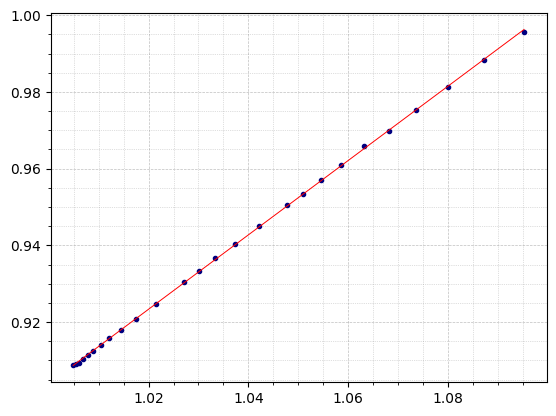

In [ ]:
def Lineal(B, x):
    a_0, a_1 = B
    return a_0 + (a_1 * x)

m = 0.93827208816
cos_theta_c = np.cos(np.radians(particle_data[0][1:,3])) # y
x = np.sqrt((particle_data[0][1:,0]*particle_data[0][1:,0]) + m*m)/(particle_data[0][1:,0])

# Estimación inicial de los parámetros (a_0, a_1) 
p0 = [0, 0.909]

# Definir el modelo para ODR
model = Model(Lineal)

# Crear el objeto Data para ODR
data_odr = Data(x, cos_theta_c) 

# Crear el objeto ODR
odr = ODR(data_odr, model, beta0=p0)

# Ejecutar el ajuste
out = odr.run()

# Obtener el valor de R²
r_squared = 1 - out.res_var / np.var(Theta_c)

# Obtener los parámetros ajustados
popt = out.beta

# Obtener los parámetros ajustados y las covarianzas
popt = out.beta
pcov = out.cov_beta

# Imprimir los valores ajustados con sus incertidumbres
print("n:", 1/popt[1], "+/-", 1/np.sqrt(pcov[1, 1]))
print("a_0:", popt[0], "+/-", np.sqrt(pcov[0, 0]), "GeV")

# Cuadrícula
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth='0.5', alpha=0.5)

plt.plot(x, cos_theta_c, 'o', markersize=3, color = 'navy')
plt.plot(x, popt[0] + x*popt[1], label='Ajuste', color="red", linestyle="-", linewidth=0.7)

n: 0.9671383748919552 +/- 0.08800712434541669
a_0: -0.13642025817138118 +/- 11.71854054703159 GeV


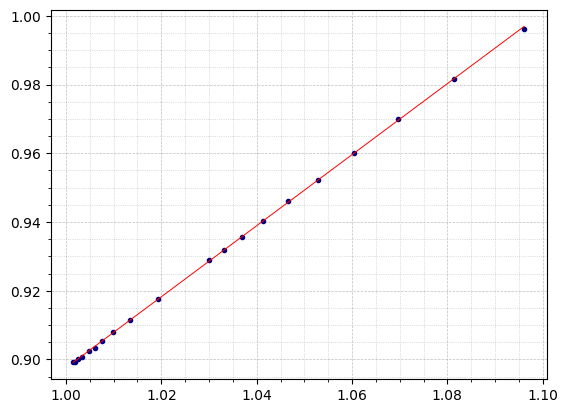

In [ ]:
m = 0.493667
cos_theta_c = np.cos(np.radians(particle_data[1][1:,3])) # y
x = np.sqrt((particle_data[1][1:,0]*particle_data[1][1:,0]) + m*m)/(particle_data[1][1:,0])

# Estimación inicial de los parámetros (a_0, a_1) 
p0 = [0, 0.9]

# Definir el modelo para ODR
model = Model(Lineal)

# Crear el objeto Data para ODR
data_odr = Data(x, cos_theta_c) 

# Crear el objeto ODR
odr = ODR(data_odr, model, beta0=p0)

# Ejecutar el ajuste
out = odr.run()

# Obtener el valor de R²
r_squared = 1 - out.res_var / np.var(Theta_c)

# Obtener los parámetros ajustados
popt = out.beta

# Obtener los parámetros ajustados y las covarianzas
popt = out.beta
pcov = out.cov_beta

# Imprimir los valores ajustados con sus incertidumbres
print("n:", 1/popt[1], "+/-", 1/np.sqrt(pcov[1, 1]))
print("a_0:", popt[0], "+/-", np.sqrt(pcov[0, 0]), "GeV")

# Cuadrícula
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth='0.5', alpha=0.5)

plt.plot(x, cos_theta_c, 'o', markersize=3, color = 'navy')
plt.plot(x, popt[0] + x*popt[1], label='Ajuste', color="red", linestyle="-", linewidth=0.7)

n: 0.9684953886728471 +/- 0.07933195850109706
a_0: -0.1345344665892033


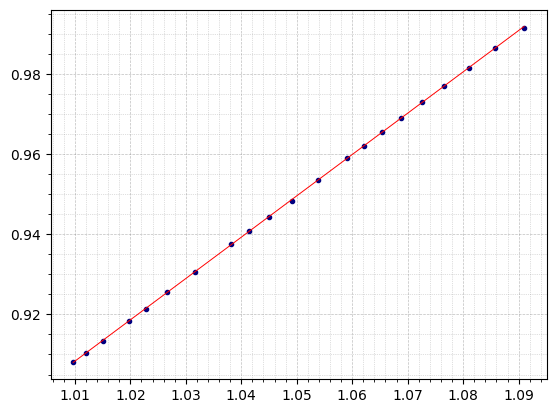

In [ ]:
m = 0.13957018
cos_theta_c = np.cos(np.radians(particle_data[2][1:,3])) # y
x = np.sqrt((particle_data[2][1:,0]*particle_data[2][1:,0]) + m*m)/(particle_data[2][1:,0])

# Estimación inicial de los parámetros (a_0, a_1) 
p0 = [0, 0.9]

# Definir el modelo para ODR
model = Model(Lineal)

# Crear el objeto Data para ODR
data_odr = Data(x, cos_theta_c) 

# Crear el objeto ODR
odr = ODR(data_odr, model, beta0=p0)

# Ejecutar el ajuste
out = odr.run()

# Obtener el valor de R²
r_squared = 1 - out.res_var / np.var(Theta_c)

# Obtener los parámetros ajustados
popt = out.beta

# Obtener los parámetros ajustados y las covarianzas
popt = out.beta
pcov = out.cov_beta

# Imprimir los valores ajustados con sus incertidumbres
print("n:", 1/popt[1], "+/-", 1/np.sqrt(pcov[1, 1]))
print("a_0:", popt[0])

# Cuadrícula
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth='0.5', alpha=0.5)

plt.plot(x, cos_theta_c, 'o', markersize=3, color = 'navy')
plt.plot(x, popt[0] + x*popt[1], label='Ajuste', color="red", linestyle="-", linewidth=0.7)